In [94]:
# pearson's correlation feature selection for numeric input and numeric output
from sklearn.datasets import make_regression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler
import datetime
import numpy as np

# read in data
import pandas as pd

In [95]:
def assess_p_correlation(corr_table_per_lag, output_labels, data_labels) -> [str]:
    print('selecting highest correlations...')
    input_features = set(data_labels) - set(output_labels)
    max_corr = pd.DataFrame(data=np.zeros((len(output_labels), len(input_features))), columns=input_features,
                            index=set(output_labels))
    max_corr_lags = {}

    for lag, corr_for_lag in enumerate(corr_table_per_lag):
        if (lag == 0): continue
        # corr_for_lag is a correlation matrix between all features for the lag
        output_cols = corr_for_lag[output_labels]
        for output_feature in output_cols:
            for input_feature, input_feature_corr in output_cols[output_feature].items():
                if (input_feature not in max_corr_lags.keys()): max_corr_lags[input_feature] = {}
                if input_feature_corr != 0 and input_feature in data_labels and input_feature not in output_labels and abs(
                        input_feature_corr) > max_corr[input_feature][output_feature]:
                    max_corr[input_feature][output_feature] = abs(input_feature_corr)
                    max_corr_lags[input_feature][output_feature] = lag

    # for each input feature, take maximum correlation to output
    max_corr_reduced = {}
    for input_feature in max_corr:
        max_corr_reduced[input_feature] = max_corr[input_feature].max()

    sorted_features = {k: v for k, v in sorted(max_corr_reduced.items(), key=lambda item: item[1])}
    return sorted_features

In [96]:

def normalize(stock_data):
    print('normalizing...')
    transformer = RobustScaler(quantile_range=(5.0, 95.0)).fit(stock_data)
    return pd.DataFrame(transformer.transform(stock_data), columns=stock_data.columns)


def relativize(stock_data, ignore_columns=[]):
    print('relativizing...')
    relative_data = stock_data.copy()
    for index, row in stock_data.iterrows():
        if index == 0 or (stock_data.loc[index - 1] == 0).all(): continue
        relative_data.loc[index] = (stock_data.loc[index] - stock_data.loc[index - 1]) / stock_data.loc[index - 1]
    
    relative_data[ignore_columns] = stock_data[ignore_columns]
    return relative_data


# Graphing

In [97]:
DAYS_LAG = 14


def select_relevant_features(stock_data, output_labels: [str]) -> [str]:
    # format input & output data
    stock_data = normalize(stock_data)
    stock_data = relativize(stock_data, ['sentiment'])

    data_labels = stock_data.columns.tolist()
    input_data = stock_data.drop(output_labels, axis=1)
    output_data = stock_data[output_labels]
    output_data_relative = output_data.copy()

    rows = input_data.values
    labels = input_data.columns
    input_labels = input_data.columns
    input_labels_number = len(input_labels)

    # time_correlation[10] - p values for each column when shifted 10 days back
    corr_table_per_lag = []

    print('calculating correlations for different time lags...')
    for i in range(0, DAYS_LAG):
        # corr = f_regression(input_data, output_data)
        # corr = np.corrcoef(np.transpose(stock_data))
        corr = abs(stock_data.corr())
        corr_table_per_lag.append(corr)
        stock_data[input_labels] = stock_data[input_labels].shift(1)
        stock_data = stock_data.fillna(0)

    return corr_table_per_lag, assess_p_correlation(corr_table_per_lag, output_labels, data_labels)

#### Read csvs

In [109]:
data = pd.read_csv('../data/raw/historical_price_data_wol.csv', sep=';')
aapl_sentiment = pd.read_csv('../data/raw/aapl_sentiment_news.csv').rename(columns={'Datetime': 'date'})

In [110]:
# Join stock data and sentiment
data['date'] = pd.to_datetime(data["date"])
aapl_sentiment['date'] = pd.to_datetime(aapl_sentiment["date"])
data = data.merge(aapl_sentiment, on='date')

data = data.sort_values(by='date')
data = data.drop(['label', 'acceptedDate', 'reportedCurrency', 'period', 'symbol', 'date', 'fillingDate'], axis=1)

corr, features = (select_relevant_features(data, ['high']))
print('done.')

normalizing...
relativizing...
calculating correlations for different time lags...
selecting highest correlations...
done.


## Graph Lag Correlation

In [111]:
import seaborn as sns
from matplotlib import pyplot

sns.set_theme(style="darkgrid")

In [112]:
# DataFrame[input_label][day] = correlation on that day
def prepare_graph_data(lag_corr, output_label, input_labels):
    data = pd.DataFrame(columns=['lag', 'corr', 'feature'], index=range(len(lag_corr) * len(lag_corr[0].columns)))
    i = 0
    for lag, df in enumerate(lag_corr):
        for input_feature in df.loc[output_label].keys():
            if input_feature not in input_labels: continue
            data.loc[i]['corr'] = df.loc[output_label][input_feature]
            data.loc[i]['feature'] = input_feature
            data.loc[i]['lag'] = lag
            i += 1
    return data.dropna().astype({'lag': 'int32', 'corr': 'float64', 'feature': 'object'}, )
    

def graph_lag_correlation(lag_corr, output_label, input_labels):
    data = prepare_graph_data(lag_corr, output_label, input_labels)

    sns.lineplot(x="lag", y="corr",
                 hue="feature",
                 data=data)


<AxesSubplot:xlabel='lag', ylabel='corr'>

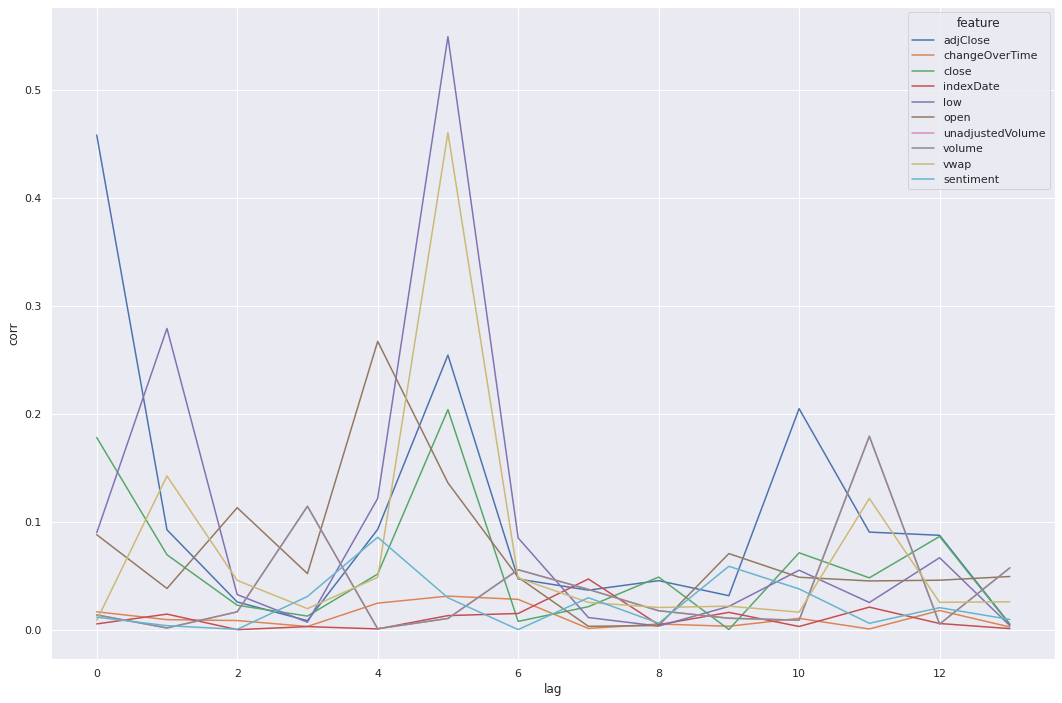

In [121]:
graph_data = prepare_graph_data(corr, 'high', list(features.keys())[-10:])
fig, ax = pyplot.subplots(figsize=(18, 12))
sns.lineplot(x="lag", y="corr",
             hue="feature", data=graph_data,ax=ax)

/home/mikhailandreev/Documents/code_py/_stock_trading_bot/venv/lib64/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/mikhailandreev/Documents/code_py/_stock_trading_bot/venv/lib64/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[]

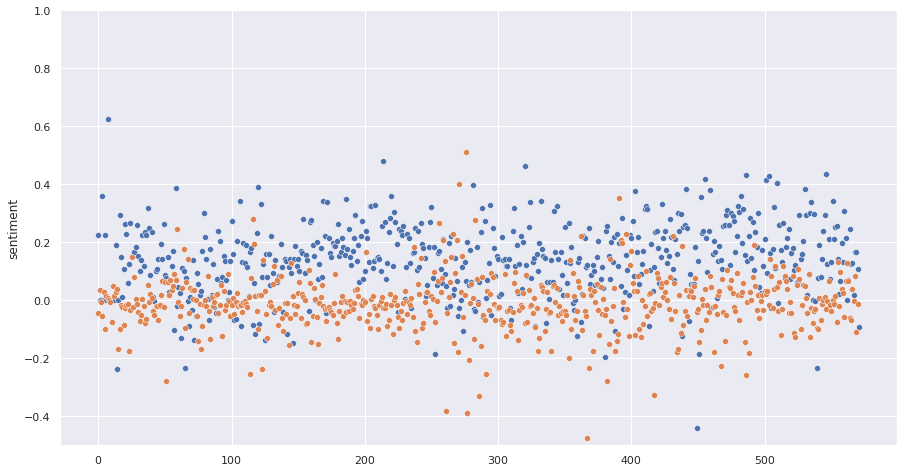

In [70]:

import matplotlib.pyplot as plt
plt.figure(figsize=(15, 8))
plt.ylim(-0.5, 1)
tips = sns.load_dataset("tips")
# sns.scatterplot(input_data['close'], output_data["high"]).plot()
sns.scatterplot(range(data.shape[0]), data["sentiment"]).plot()
sns.scatterplot(range(data.shape[0]), relative_data["high"]*5).plot()

In [45]:
relative_data = relativize(data)

relativizing...


In [46]:
data.head()

,Unnamed: 0,costAndExpenses,costOfRevenue,depreciationAndAmortization,ebitda,ebitdaratio,eps,epsdiluted,generalAndAdministrativeExpenses,grossProfit,...,changePercent,close,high,indexDate,low,open,unadjustedVolume,volume,vwap,sentiment
571,573,194697000000,163756000000,10903000000,81801000000,0.307991,3.0025,2.9775,16705000000,101839000000,...,464.0,42.722500,42.750000,20190212,42.424999,42.525002,89134000.0,89134000.0,42.63250,0.2263
570,572,194697000000,163756000000,10903000000,81801000000,0.307991,3.0025,2.9775,16705000000,101839000000,...,-706.0,42.544998,43.119999,20190213,42.480000,42.847500,89960800.0,89960800.0,42.71500,0.0000
569,571,194697000000,163756000000,10903000000,81801000000,0.307991,3.0025,2.9775,16705000000,101839000000,...,642.0,42.700001,42.814999,20190214,42.345001,42.427502,87342800.0,87342800.0,42.62000,0.0000
568,569,194697000000,163756000000,10903000000,81801000000,0.307991,3.0025,2.9775,16705000000,101839000000,...,719.0,42.732498,42.860001,20190219,42.372501,42.427502,75891200.0,75891200.0,42.65500,0.3612
567,568,194697000000,163756000000,10903000000,81801000000,0.307991,3.0025,2.9775,16705000000,101839000000,...,491.0,43.007500,43.330002,20190220,42.747501,42.797501,104457600.0,104457600.0,43.02833,0.0000
